In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.getcwd().replace("notebooks","utils"))

import general_purpose as gp
from co2_functions import Predicting
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, RobustScaler
import scipy.stats as ss
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from sklearn.model_selection import cross_val_score

Módulo General Listo Para Usarse 💻
Hey!, el módulo co2 ha sido importado correctamente 🥳


# Cargamos los datos:

In [2]:
df = gp.dataframes_charger("df_v3.csv")
df.head()

,GDP,Population,Energy_production,Energy_consumption,CO2_emission,per_capita_production,Energy_intensity_by_GDP,balance,eficiency,energy_dependecy,use_intensity_pc,co2_pc,latitude,longitude,Year,Country,Energy_type,CODE_x,continent
0,279.389,15182.60,0.150,0.155,0.0,104.341,5.670,-0.005,0.0,0.001,0.0,0.0,6.424,-66.59,1980-01-01,Venezuela,renewables_n_other,VEN,South America
1,279.389,15182.60,5.000,0.812,0.0,104.341,5.670,4.188,0.0,0.003,0.0,0.0,6.424,-66.59,1980-01-01,Venezuela,petroleum_n_other_liquids,VEN,South America
2,279.389,15182.60,0.616,0.616,0.0,104.341,5.670,0.000,0.0,0.002,0.0,0.0,6.424,-66.59,1980-01-01,Venezuela,natural_gas,VEN,South America
3,279.389,15182.60,0.001,0.002,0.0,104.341,5.670,-0.000,0.0,0.000,0.0,0.0,6.424,-66.59,1980-01-01,Venezuela,coal,VEN,South America
4,278.376,15597.88,0.156,0.161,0.0,110.257,6.178,-0.005,0.0,0.001,0.0,0.0,6.424,-66.59,1981-01-01,Venezuela,renewables_n_other,VEN,South America


En un principio eliminamos algunas variables que sabemos que no nos van ha hacer falta para nuestro modelo de regresión. Más adelante veremos si es necesario eliminar algunas otras:

In [21]:
df_2 = df.drop(columns=["continent","CODE_x","latitude","longitude"])
df_2.head()

,GDP,Population,Energy_production,Energy_consumption,CO2_emission,per_capita_production,Energy_intensity_by_GDP,balance,eficiency,energy_dependecy,use_intensity_pc,co2_pc,Year,Country,Energy_type
0,279.389,15182.60,0.150,0.155,0.0,104.341,5.670,-0.005,0.0,0.001,0.0,0.0,1980-01-01,Venezuela,renewables_n_other
1,279.389,15182.60,5.000,0.812,0.0,104.341,5.670,4.188,0.0,0.003,0.0,0.0,1980-01-01,Venezuela,petroleum_n_other_liquids
2,279.389,15182.60,0.616,0.616,0.0,104.341,5.670,0.000,0.0,0.002,0.0,0.0,1980-01-01,Venezuela,natural_gas
3,279.389,15182.60,0.001,0.002,0.0,104.341,5.670,-0.000,0.0,0.000,0.0,0.0,1980-01-01,Venezuela,coal
4,278.376,15597.88,0.156,0.161,0.0,110.257,6.178,-0.005,0.0,0.001,0.0,0.0,1981-01-01,Venezuela,renewables_n_other


La variable Energy_type la vamos a necesitar, pero codificada, por lo que al tratarse una variable que consideramos sí tiene un orden o peso entre ellas en relación al co2 que cada una de las fuentes de energía emiten, las vamos a codificar con un mapeado, en función de los parámetros establecidos, de emisión de co2, en la parte de clusterización, es decir:
* 0: poco contaminante, energías renovables
* 1: algo contaminante, nuclear
* 2: contaminante, gas natural
* 3: bastante contaminante, petróleo
* 4: muy contaminante, carbón

In [22]:
own_scale = {"renewables_n_other":0,"nuclear":1,"natural_gas":2,"petroleum_n_other_liquids":3,"coal":4}
df_2 = df_2.copy()
df_2["energy_type"] = df.Energy_type.map(own_scale)
df_2.head()

,GDP,Population,Energy_production,Energy_consumption,CO2_emission,per_capita_production,Energy_intensity_by_GDP,balance,eficiency,energy_dependecy,use_intensity_pc,co2_pc,Year,Country,Energy_type,energy_type
0,279.389,15182.60,0.150,0.155,0.0,104.341,5.670,-0.005,0.0,0.001,0.0,0.0,1980-01-01,Venezuela,renewables_n_other,0
1,279.389,15182.60,5.000,0.812,0.0,104.341,5.670,4.188,0.0,0.003,0.0,0.0,1980-01-01,Venezuela,petroleum_n_other_liquids,3
2,279.389,15182.60,0.616,0.616,0.0,104.341,5.670,0.000,0.0,0.002,0.0,0.0,1980-01-01,Venezuela,natural_gas,2
3,279.389,15182.60,0.001,0.002,0.0,104.341,5.670,-0.000,0.0,0.000,0.0,0.0,1980-01-01,Venezuela,coal,4
4,278.376,15597.88,0.156,0.161,0.0,110.257,6.178,-0.005,0.0,0.001,0.0,0.0,1981-01-01,Venezuela,renewables_n_other,0


In [23]:
# reorganizamos las columnas y las renombramos por facilidad de uso:
df_2 = df_2.drop(columns="Energy_type")
df_2 = df_2.rename(columns=dict(zip(df_2.columns,df_2.columns.str.lower())))
df_2 = df_2[["gdp","population","energy_production","energy_consumption",
            "co2_emission","per_capita_production","energy_intensity_by_gdp",
            "balance","eficiency","energy_dependecy","use_intensity_pc",
            "co2_pc","energy_type","year","country"]]

In [24]:
df_2.head()

,gdp,population,energy_production,energy_consumption,co2_emission,per_capita_production,energy_intensity_by_gdp,balance,eficiency,energy_dependecy,use_intensity_pc,co2_pc,energy_type,year,country
0,279.389,15182.60,0.150,0.155,0.0,104.341,5.670,-0.005,0.0,0.001,0.0,0.0,0,1980-01-01,Venezuela
1,279.389,15182.60,5.000,0.812,0.0,104.341,5.670,4.188,0.0,0.003,0.0,0.0,3,1980-01-01,Venezuela
2,279.389,15182.60,0.616,0.616,0.0,104.341,5.670,0.000,0.0,0.002,0.0,0.0,2,1980-01-01,Venezuela
3,279.389,15182.60,0.001,0.002,0.0,104.341,5.670,-0.000,0.0,0.000,0.0,0.0,4,1980-01-01,Venezuela
4,278.376,15597.88,0.156,0.161,0.0,110.257,6.178,-0.005,0.0,0.001,0.0,0.0,0,1981-01-01,Venezuela


Vamos a ver que distribución tienen nuestros datos numéricos:

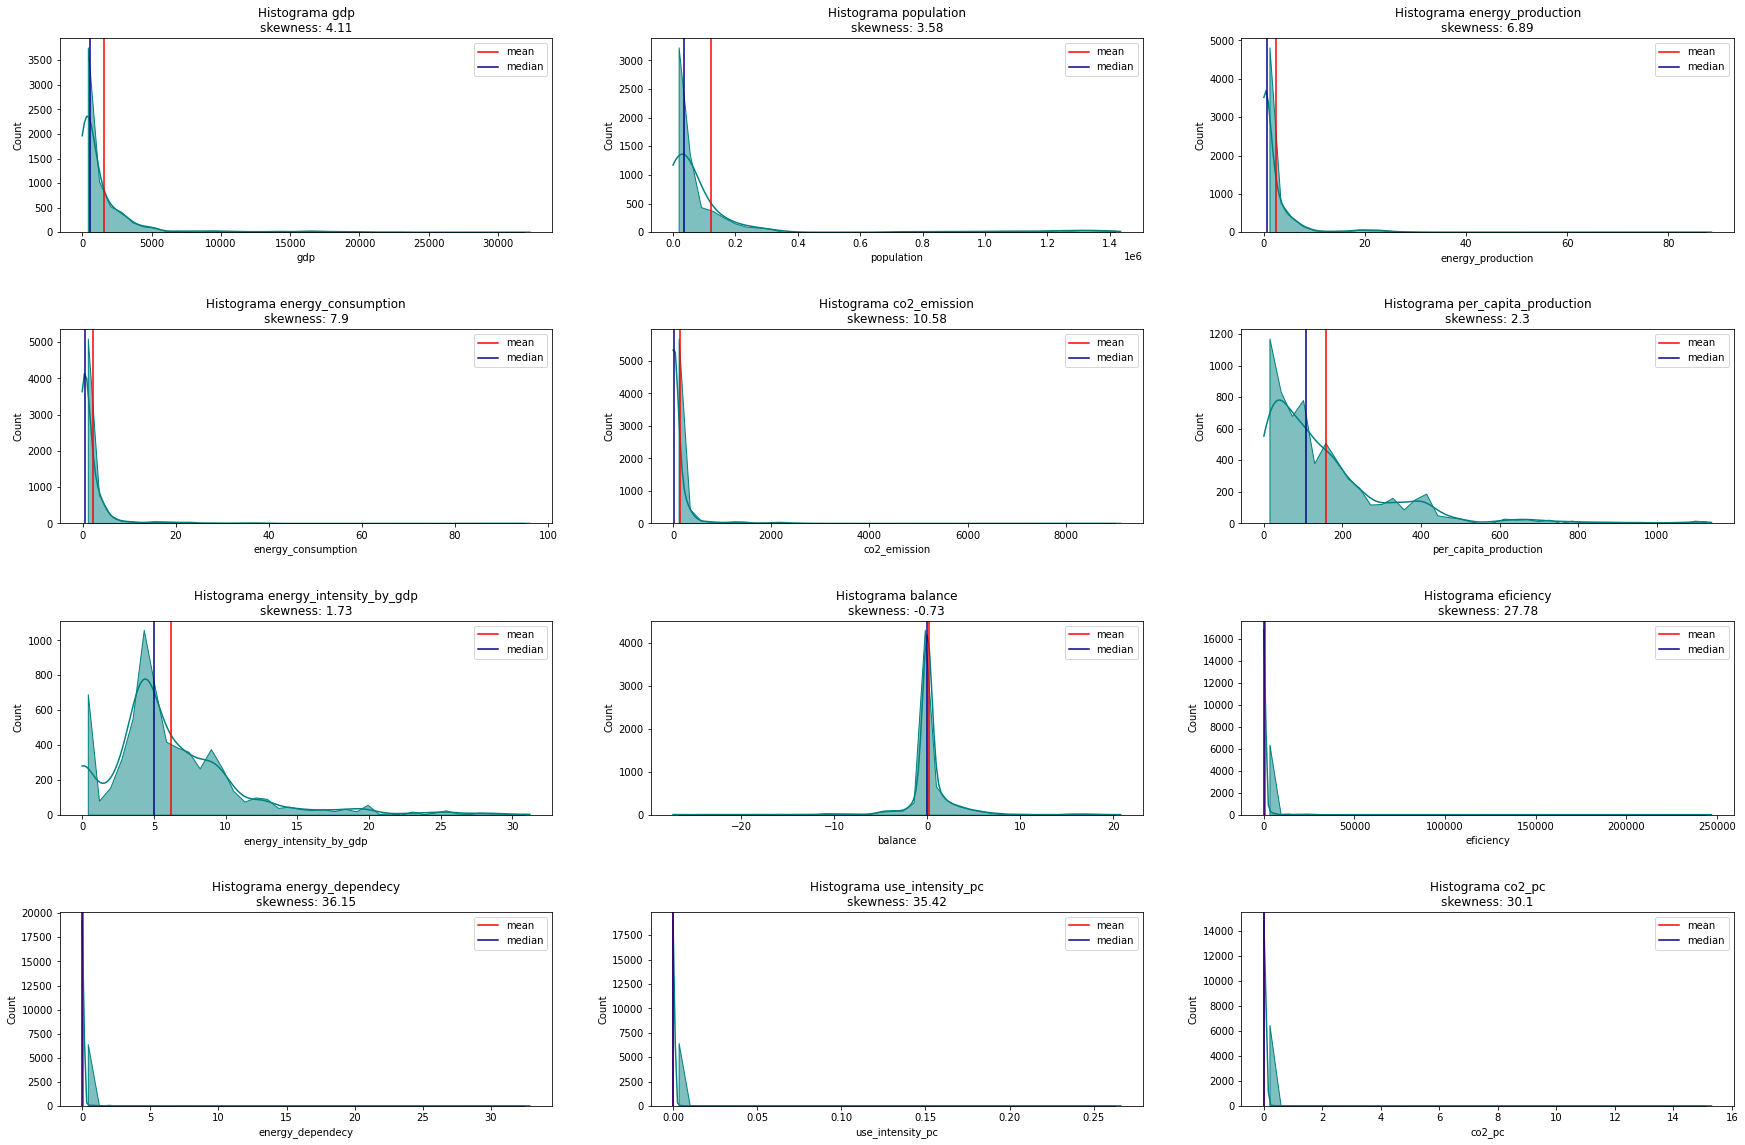

In [25]:
all_vars = df_2.columns[:len(df_2.columns)-3]
fig1 = plt.figure(figsize=(30,25))
fig1.subplots_adjust(hspace=0.5, wspace=0.2)

for i in range(0,len(all_vars)):
    
    ax = fig1.add_subplot(5, 3,i+1)
    pos = all_vars[i]
    sns.histplot(df_2[pos],color='teal',bins=40,kde=True,element="poly")
    plt.axvline(df_2[pos].mean(),color="r",label="mean")
    plt.axvline(df_2[pos].median(),color="darkblue",label="median")
    plt.title(f'Histograma {all_vars[i]}\nskewness: {round(df_2[pos].skew(),2)}') 
    plt.legend()
plt.show()

Observamos que todos ellos tienen poca similitud con una distribución normal. En general son distribuciones asimétricas con cola a la derecha dado que tenemos países con valores muy grandes en relación a los demás que tiran de la media hacia valores altos, dejando a esta a la derecha de la mediana, excepto balance. Balance podemos ver que es más simétrica pero con una kurtosis bastante acentuada, teniendo por tanto una forma leptocurtica. De forma mayoritaria,lo que se ve es que:
1. existen variables con escalas muy diferentes entre ellas, así podemos ver que gdp tiene valores en cientos de miles, per capita production en cientos y en miles y co2_pc en unidades
2. que los datos tienen bastantes valores extremos en general  
Por esta razón, hemos decidido que vamos a escalarlos para que los algoritmos puedan trabajar mejor con los datos. Dadas las características de nuestros datos hemos decidido que vamos a usar uno de estos dos:
* PowerTransformer: se usará yeo-jhonson debido en que algunas variables tenemos valores negativos y box-cox no lo soporta y nos gusta porque es adecuada cuando la varianza de los datos no es constante o muy grande, ayudando a estabilizarla y minimiza la
* RobustScaler: está basado en percentiles y por tanto no está influenciado por outliers. Esto resulta en que el rango resultante de valores transformados sea mayor que otros transformadores pero similar al de la variable.

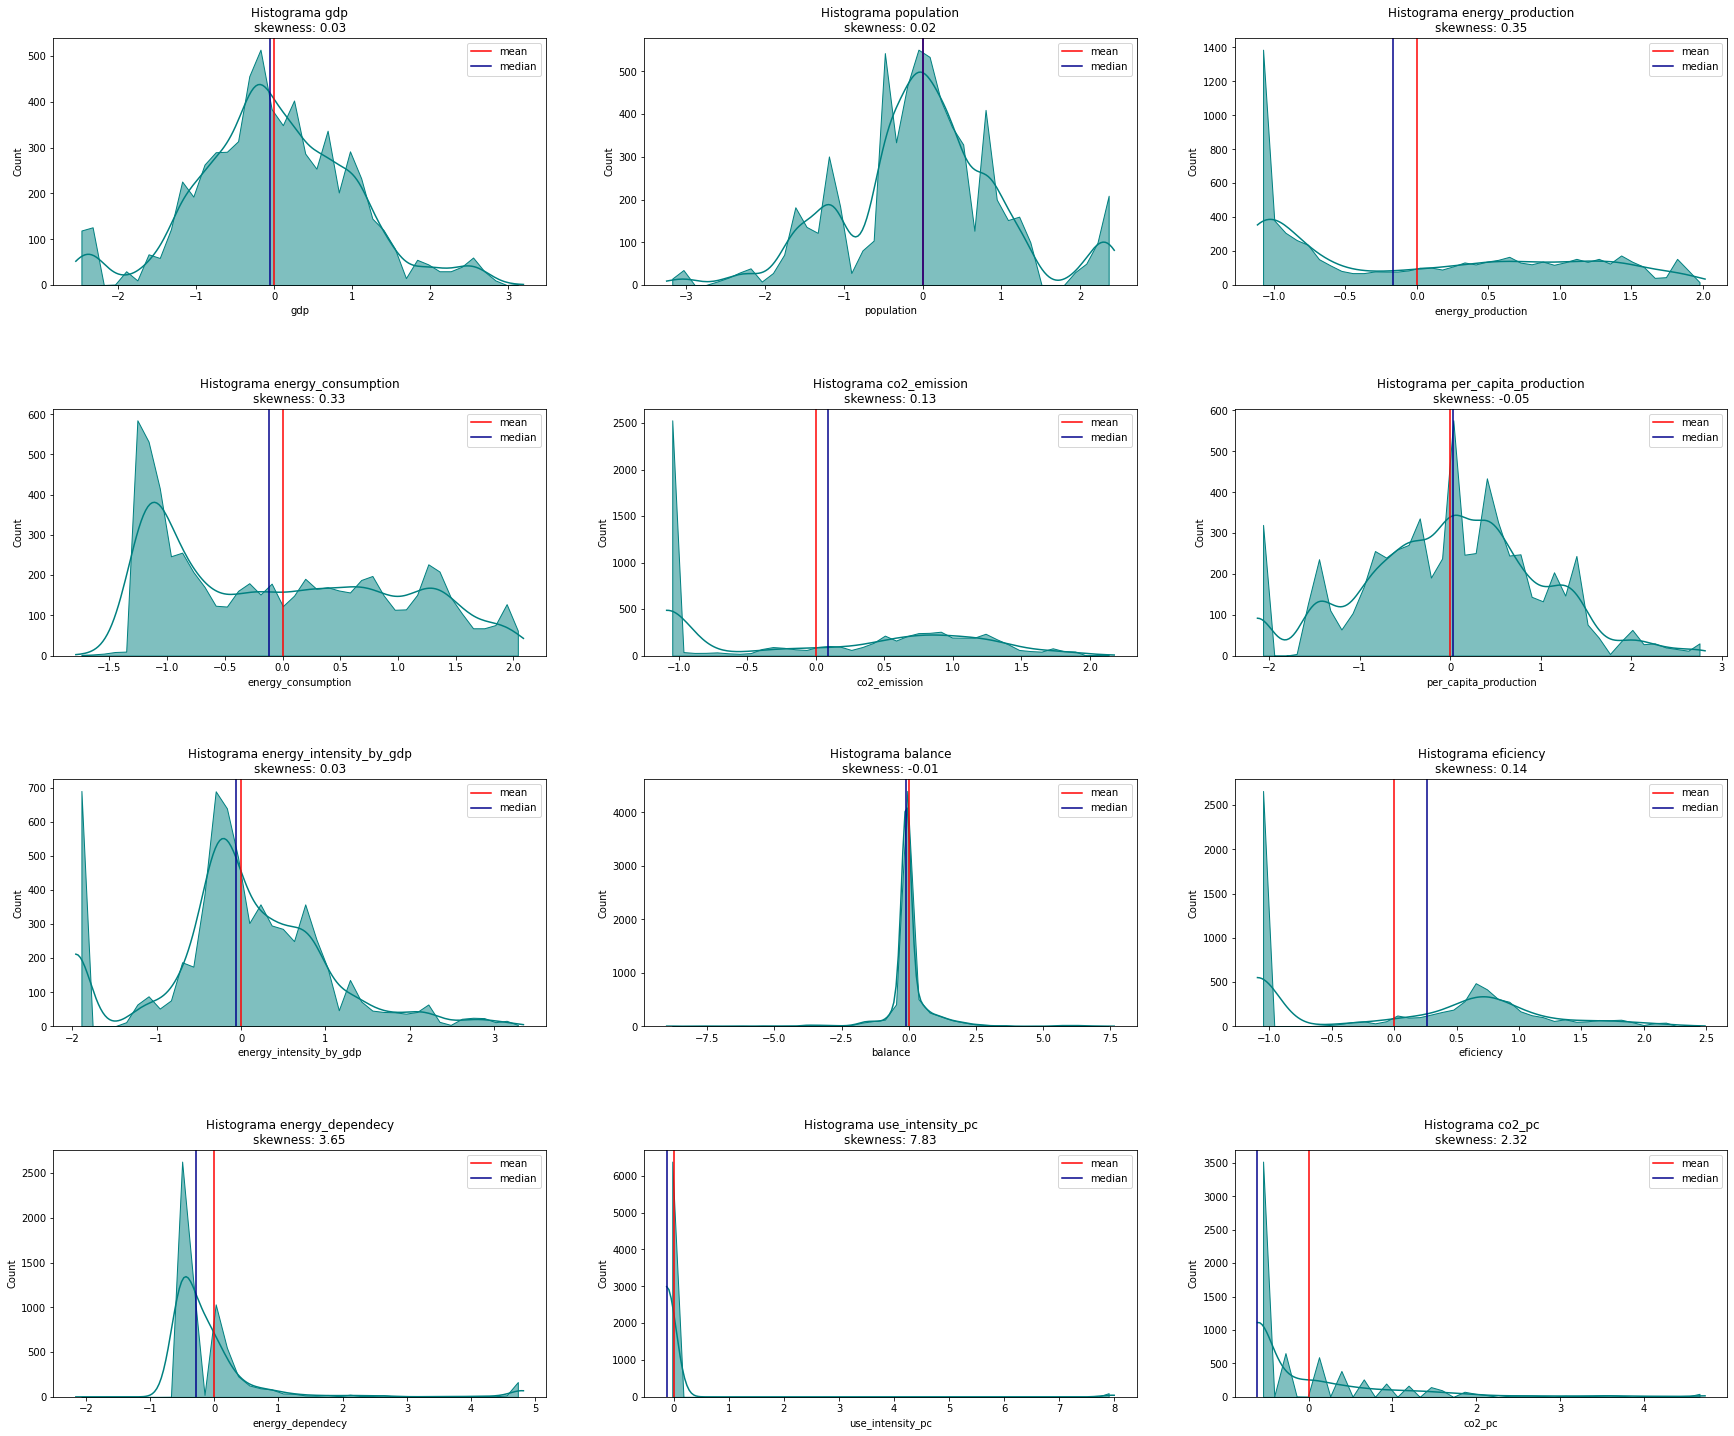

In [26]:
# Transformación con PowerTransformer
power_trans = PowerTransformer()
power_trans.fit(df_2[all_vars])
power_trans_data = power_trans.transform(df_2[all_vars])
norm_data = pd.DataFrame(power_trans_data,columns=all_vars)

fig1 = plt.figure(figsize=(30,25))
fig1.subplots_adjust(hspace=0.5, wspace=0.2)

for i in range(0,len(all_vars)):
    
    ax = fig1.add_subplot(4, 3,i+1)
    pos = all_vars[i]
    sns.histplot(norm_data[pos],color='teal',bins=40,kde=True,element="poly")
    plt.axvline(norm_data[pos].mean(),color="r",label="mean")
    plt.axvline(norm_data[pos].median(),color="darkblue",label="median")
    plt.title(f'Histograma {all_vars[i]}\nskewness: {round(norm_data[pos].skew(),2)}')  
    plt.legend()
plt.show()

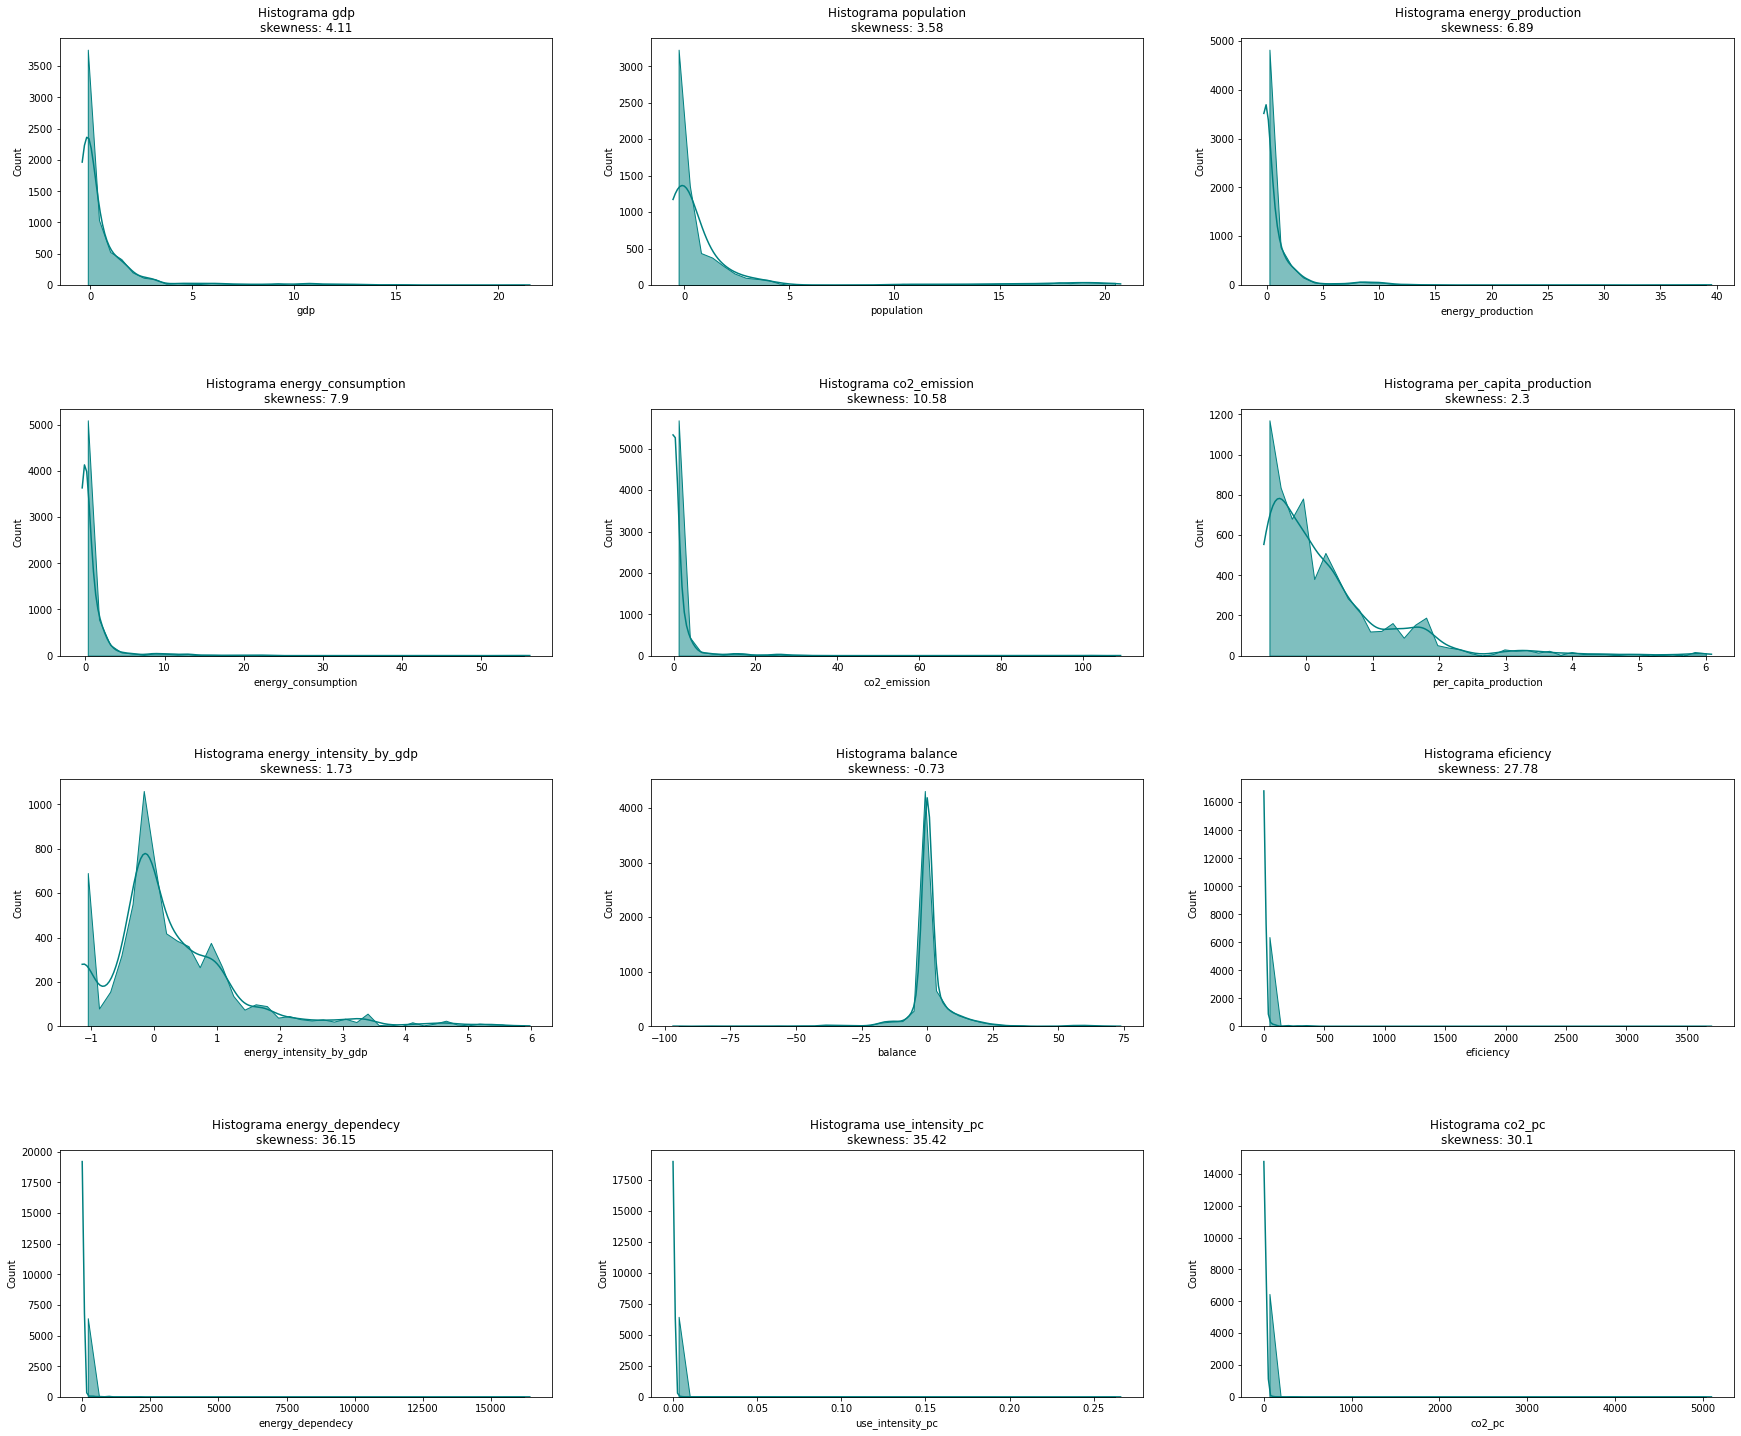

In [27]:
# Transformación con RobustScaler
robust_trans = RobustScaler()
robust_trans.fit(df_2[all_vars])
robust_trans_data = robust_trans.transform(df_2[all_vars])
norm_data_robust = pd.DataFrame(robust_trans_data,columns=all_vars)
fig1 = plt.figure(figsize=(30,25))
fig1.subplots_adjust(hspace=0.5, wspace=0.2)

for i in range(0,len(all_vars)):
    
    ax = fig1.add_subplot(4, 3,i+1)
    pos = all_vars[i]
    sns.histplot(norm_data_robust[pos],color='teal',bins=40,kde=True,element="poly")
    plt.title(f'Histograma {all_vars[i]}\nskewness: {round(norm_data_robust[pos].skew(),2)}')  
plt.show()

Vemos que RobustScaler ha cambiado la escala de los datos manteniendo la asimetría, pero aún así tenemos escalas diferentes entre ellos, por lo que decidimos quedarnos con powertransformer que nos centra los datos en torno a distribuciones más parecidas a la normal con escalas parecidas entre ellas también

In [29]:
faltante = df_2[["energy_type","year","country"]]
df_enc_trans = pd.merge(norm_data,faltante,left_index=True,right_index=True)
df_enc_trans.head()

,gdp,population,energy_production,energy_consumption,co2_emission,per_capita_production,energy_intensity_by_gdp,balance,eficiency,energy_dependecy,use_intensity_pc,co2_pc,energy_type,year,country
0,-0.464369,-0.497205,-0.762928,-0.796767,-1.089275,0.007172,0.092487,-0.093147,-1.094163,-0.279813,-0.125788,-0.609601,0,1980-01-01,Venezuela
1,-0.464369,-0.497205,1.371884,0.193666,-1.089275,0.007172,0.092487,1.415672,-1.094163,0.154807,-0.125788,-0.609601,3,1980-01-01,Venezuela
2,-0.464369,-0.497205,-0.057938,-0.020843,-1.089275,0.007172,0.092487,-0.091399,-1.094163,-0.057550,-0.125788,-0.609601,2,1980-01-01,Venezuela
3,-0.464369,-0.497205,-1.113044,-1.203952,-1.089275,0.007172,0.092487,-0.091399,-1.094163,-0.512453,-0.125788,-0.609601,4,1980-01-01,Venezuela
4,-0.466362,-0.481889,-0.750570,-0.782897,-1.089275,0.052672,0.205185,-0.093147,-1.094163,-0.279813,-0.125788,-0.609601,0,1981-01-01,Venezuela


In [30]:
df_enc_trans.dtypes

gdp                        float64
population                 float64
energy_production          float64
energy_consumption         float64
co2_emission               float64
per_capita_production      float64
energy_intensity_by_gdp    float64
balance                    float64
eficiency                  float64
energy_dependecy           float64
use_intensity_pc           float64
co2_pc                     float64
energy_type                  int64
year                        object
country                     object
dtype: object

Miramos el variance inflator factor (vif). El método VIF nos sirve para detectar la multicolinealidad. Esta se produce cuando dos variables están muy correlacionadas y por tanto contienen información similar entre ellas. En este sentido, el VIF es un ratio que pone en relación la varianza del modelo entero con la varianza del mismo modelo pero solo con la variable a estudiar, es decir, cuanto contribuye la varianza de cada variable independiente en la varianza del modelo en su conjunto. En resumen, la multicolinealidad puede no interferir con el rendimiento del modelo, pero afecta negativamente a la interpretación de los predictores utilizados para construir el modelo.

In [38]:
Predicting.compute_vif(df_enc_trans,vars)

,Variable,VIF
0,gdp,8.614649
4,co2_emission,8.331343
3,energy_consumption,6.992861
1,population,6.896072
8,eficiency,4.956650
2,energy_production,4.347325
5,per_capita_production,3.640572
9,energy_dependecy,3.370902
11,co2_pc,3.066047
6,energy_intensity_by_gdp,1.950127


Vemos que `[gdp,co2_emission,population,energy_consumption]` tienen un vif superior a 5, pero un error que se suele cometer al principio es eliminar todas las variables de una vez. Sin embargo, la selección de variables tiene mejor resultados si se va eliminando una cada vez y se va comprobando como queda el modelo. Esto asegura que la perdida de información sea mínima. Además, las variables con mayor vif también son de las que a priori consideramos más importantes en el modelo. Por lo que no podemos de momento tomar una decisión apresurada sobre ellas. 
Vamos a crear un baseline realizando una regresión lineal con todas las variables con la librería statsmodels. Esta librería nos provee de información sobre la multicolinealidad, la bondad del ajuste y pruebas paramétricas para conocer si las variables son necesarias o no en el modelo para predecir el nivel de co2 a emitir, entre otros que miraremos:

In [39]:
x = df_enc_trans.drop(columns=["eficiency","year","country"])
y = df_enc_trans.eficiency

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1234)

In [40]:
model = sm.OLS(y_train.values,x_train.values)
results = model.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.802    
Dependent Variable:     y                AIC:                         6307.0397
Date:                   2022-08-17 12:08 BIC:                         6385.6866
No. Observations:       5187             Log-Likelihood:              -3141.5  
Df Model:               12               F-statistic:                 1755.    
Df Residuals:           5175             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.803            Scale:                       0.19706  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1          0.0207        0.0182        1.1408      0.2540      -0.0149       0.0563
x2         -0.0368        0.0163       -2.2586      0.0239      -0.0688      -0.0049
x3         -0.4014        0.0117      -34.4367      0.0000      -0.4243      -0.3786
x4          0.0855        0.0160        5.3343      0.0000       0.0541       0.1169
x5          0.9989        0.0108       92.2491      0.0000       0.9776       1.0201
x6         -0.0697        0.0118       -5.9211      0.0000      -0.0928      -0.0466
x7          0.0025        0.0086        0.2949      0.7681      -0.0143       0.0194
x8         -0.0262        0.0074       -3.5451      0.0004      -0.0406      -0.0117
x9          0.0143        0.0114        1.2568      0.2089      -0.0080       0.0365
x10        -0.0015        0.0077       -0.1954      0.8451      -0.0166       0.0136
x11        -0.0254        0.0109       -2.3228      0.0202      -0.0468      -0.0040
x12         0.0150        0.0026        5.7999      0.0000       0.0099       0.0201
-------------------------------------------------------------------------------
Omnibus:                  777.842          Durbin-Watson:             1.965    
Prob(Omnibus):            0.000            Jarque-Bera (JB):          10340.149
Skew:                     0.249            Prob(JB):                  0.000    
Kurtosis:                 9.899            Condition No.:             11       
===============================================================================

"""

En primer lugar, statsmodels no nos está avisando de que tengamos una gran multicolinealidad. Sin embargo, según los resultados del primer modelo la variable x7 no es estadísticamente independiente y por tanto en teoría nos las podríamos quitar de nuestro modelo y mejorarlo. Vamos a ver si es así:

In [45]:
indice_variables = pd.DataFrame(x_train.columns,columns=["variables"],index=np.arange(1,13))
indice_variables

,variables
1,gdp
2,population
3,energy_production
4,energy_consumption
5,co2_emission
6,per_capita_production
7,energy_intensity_by_gdp
8,balance
9,energy_dependecy
10,use_intensity_pc


In [47]:
indice_variables.iloc[[6]].values

array([['energy_intensity_by_gdp']], dtype=object)

In [48]:
model2 = sm.OLS(y_train.values,x_train.drop(columns="energy_intensity_by_gdp").values)
results2 = model2.fit()
results2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.802    
Dependent Variable:     y                AIC:                         6305.1268
Date:                   2022-08-17 12:13 BIC:                         6377.2198
No. Observations:       5187             Log-Likelihood:              -3141.6  
Df Model:               11               F-statistic:                 1915.    
Df Residuals:           5176             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.803            Scale:                       0.19702  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1          0.0183        0.0162        1.1282      0.2593      -0.0135       0.0502
x2         -0.0344        0.0142       -2.4331      0.0150      -0.0622      -0.0067
x3         -0.4014        0.0117      -34.4404      0.0000      -0.4242      -0.3785
x4          0.0859        0.0159        5.3931      0.0000       0.0547       0.1172
x5          0.9989        0.0108       92.2579      0.0000       0.9776       1.0201
x6         -0.0675        0.0090       -7.4999      0.0000      -0.0851      -0.0498
x7         -0.0262        0.0074       -3.5507      0.0004      -0.0407      -0.0117
x8          0.0134        0.0110        1.2219      0.2218      -0.0081       0.0350
x9         -0.0012        0.0076       -0.1567      0.8755      -0.0161       0.0137
x10        -0.0254        0.0109       -2.3232      0.0202      -0.0468      -0.0040
x11         0.0150        0.0026        5.7998      0.0000       0.0099       0.0201
-------------------------------------------------------------------------------
Omnibus:                  777.438          Durbin-Watson:             1.965    
Prob(Omnibus):            0.000            Jarque-Bera (JB):          10332.120
Skew:                     0.248            Prob(JB):                  0.000    
Kurtosis:                 9.896            Condition No.:             10       
===============================================================================

"""

In [49]:
indice_variables = pd.DataFrame(x_train.drop(columns="energy_intensity_by_gdp").columns,
columns=["variables"],
index=np.arange(1,12))
indice_variables

,variables
1,gdp
2,population
3,energy_production
4,energy_consumption
5,co2_emission
6,per_capita_production
7,balance
8,energy_dependecy
9,use_intensity_pc
10,co2_pc


In [50]:
# Eliminamos x9:
model3 = sm.OLS(y_train.values,x_train.drop(columns=["energy_intensity_by_gdp","use_intensity_pc"]).values)
results3 = model3.fit()
results3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.802    
Dependent Variable:     y                AIC:                         6303.1514
Date:                   2022-08-17 12:21 BIC:                         6368.6905
No. Observations:       5187             Log-Likelihood:              -3141.6  
Df Model:               10               F-statistic:                 2107.    
Df Residuals:           5177             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.803            Scale:                       0.19699  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1          0.0177        0.0157        1.1252      0.2605      -0.0131       0.0485
x2         -0.0339        0.0138       -2.4652      0.0137      -0.0609      -0.0069
x3         -0.4013        0.0116      -34.4928      0.0000      -0.4241      -0.3785
x4          0.0860        0.0159        5.4003      0.0000       0.0548       0.1172
x5          0.9992        0.0106       93.8788      0.0000       0.9783       1.0200
x6         -0.0671        0.0087       -7.7013      0.0000      -0.0842      -0.0500
x7         -0.0262        0.0074       -3.5551      0.0004      -0.0407      -0.0118
x8          0.0129        0.0105        1.2301      0.2187      -0.0077       0.0336
x9         -0.0259        0.0103       -2.5230      0.0117      -0.0461      -0.0058
x10         0.0150        0.0026        5.7985      0.0000       0.0099       0.0201
-------------------------------------------------------------------------------
Omnibus:                  777.423          Durbin-Watson:             1.965    
Prob(Omnibus):            0.000            Jarque-Bera (JB):          10335.616
Skew:                     0.248            Prob(JB):                  0.000    
Kurtosis:                 9.898            Condition No.:             10       
===============================================================================

"""

El aic y el bic han bajado, pero en tal cantidad que no es relevante. La bondad del ajuste sigue siendo la misma 0.803 y por lo tanto hemos simplificado el modelo porque vemos que no nos hacen falta todas las variables para tener un resultado que podemos considerar identico. En ese sentido puede suponer una mejora. Sin embargo, vamos a crear un modelo con los datos que vimos de independencia y vif:
1. Vamos a ir eliminando variables hasta que no tengamos multicolinealidad según vif

y vemos que la cosa ha mejorado bastante, vamos ahora a ir eliminando hasta que tengamos un resultado aceptable:

In [51]:
vars

Index(['gdp', 'population', 'energy_production', 'energy_consumption',
       'co2_emission', 'per_capita_production', 'energy_intensity_by_gdp',
       'balance', 'eficiency', 'energy_dependecy', 'use_intensity_pc',
       'co2_pc', 'energy_type'],
      dtype='object')

In [57]:
new_vars = [x for x in vars if x not in ["population","eficiency"]]
Predicting.compute_vif(df_enc_trans,new_vars)

,Variable,VIF
2,energy_consumption,6.902726
3,co2_emission,4.163060
0,gdp,3.746970
1,energy_production,3.565083
7,energy_dependecy,3.064186
9,co2_pc,2.852238
4,per_capita_production,1.807216
10,energy_type,1.796740
8,use_intensity_pc,1.493269
5,energy_intensity_by_gdp,1.491735


In [58]:
new_vars2 = [x for x in vars if x not in ["population","energy_consumption","eficiency"]]
Predicting.compute_vif(df_enc_trans,new_vars2)

,Variable,VIF
2,co2_emission,3.404977
8,co2_pc,2.852235
1,energy_production,2.515911
6,energy_dependecy,2.377716
0,gdp,2.372908
3,per_capita_production,1.803222
9,energy_type,1.743067
7,use_intensity_pc,1.492164
4,energy_intensity_by_gdp,1.482584
5,balance,1.396694


En este punto ya tenemos a todas las variables con un vif inferior a 5 por lo que ya no tendríamos problemas de multicolinealidad:

In [78]:
vif_df = Predicting.compute_vif(df_enc_trans,new_vars2)
golden_vars = vif_df.Variable.values
model3 = sm.OLS(y_train.values,x_train[golden_vars].values)
results3 = model3.fit()
results3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.801    
Dependent Variable:     y                AIC:                         6337.5847
Date:                   2022-08-17 13:05 BIC:                         6403.1238
No. Observations:       5187             Log-Likelihood:              -3158.8  
Df Model:               10               F-statistic:                 2090.    
Df Residuals:           5177             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.801            Scale:                       0.19830  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1          1.0205        0.0098      103.6168      0.0000       1.0012       1.0398
x2         -0.0176        0.0106       -1.6608      0.0968      -0.0383       0.0032
x3         -0.3686        0.0098      -37.7383      0.0000      -0.3877      -0.3495
x4          0.0344        0.0096        3.5793      0.0003       0.0156       0.0533
x5          0.0299        0.0094        3.1765      0.0015       0.0114       0.0483
x6         -0.0495        0.0083       -5.9565      0.0000      -0.0657      -0.0332
x7          0.0139        0.0026        5.3613      0.0000       0.0088       0.0189
x8          0.0019        0.0074        0.2505      0.8022      -0.0127       0.0164
x9         -0.0033        0.0075       -0.4370      0.6621      -0.0179       0.0114
x10        -0.0356        0.0072       -4.9488      0.0000      -0.0497      -0.0215
-------------------------------------------------------------------------------
Omnibus:                 733.228           Durbin-Watson:              1.965   
Prob(Omnibus):           0.000             Jarque-Bera (JB):           9344.106
Skew:                    0.192             Prob(JB):                   0.000   
Kurtosis:                9.564             Condition No.:              6       
===============================================================================

"""

In [79]:
y_1 = y_train.values
x_1 = x_train[golden_vars].values
model4 = LinearRegression()
cvs = cross_val_score(model4,x_1,y_1,scoring="r2",cv=10)
print(f"la media de r2 obtenida por el modelo es {cvs.mean()}")

la media de r2 obtenida por el modelo es 0.8050847413940987


El modelo ha empeorado, vamos a eliminar la 9 de todas maneras a ver como queda:

In [80]:
golden_vars

array(['co2_emission', 'co2_pc', 'energy_production', 'energy_dependecy',
       'gdp', 'per_capita_production', 'energy_type', 'use_intensity_pc',
       'energy_intensity_by_gdp', 'balance'], dtype=object)

In [81]:
golden_vars = np.delete(golden_vars,np.where(golden_vars=="energy_intensity_by_gdp"))

In [82]:
model4 = sm.OLS(y_train.values,x_train[golden_vars].values)
results4 = model4.fit()
results4.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.801    
Dependent Variable:     y                AIC:                         6335.7761
Date:                   2022-08-17 13:07 BIC:                         6394.7613
No. Observations:       5187             Log-Likelihood:              -3158.9  
Df Model:               9                F-statistic:                 2322.    
Df Residuals:           5178             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.801            Scale:                       0.19827  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1          1.0201        0.0098      104.1906      0.0000       1.0009       1.0392
x2         -0.0169        0.0105       -1.6134      0.1067      -0.0374       0.0036
x3         -0.3692        0.0097      -38.1417      0.0000      -0.3881      -0.3502
x4          0.0348        0.0096        3.6336      0.0003       0.0160       0.0536
x5          0.0302        0.0094        3.2288      0.0013       0.0119       0.0486
x6         -0.0512        0.0073       -7.0487      0.0000      -0.0655      -0.0370
x7          0.0139        0.0026        5.3696      0.0000       0.0088       0.0190
x8          0.0019        0.0074        0.2504      0.8023      -0.0127       0.0164
x9         -0.0355        0.0072       -4.9371      0.0000      -0.0496      -0.0214
-------------------------------------------------------------------------------
Omnibus:                 733.553           Durbin-Watson:              1.965   
Prob(Omnibus):           0.000             Jarque-Bera (JB):           9340.853
Skew:                    0.194             Prob(JB):                   0.000   
Kurtosis:                9.563             Condition No.:              6       
===============================================================================

"""

In [83]:
y_4 = y_train.values
x_4 = x_train[golden_vars].values
model4 = LinearRegression()
cvs = cross_val_score(model4,x_4,y_4,scoring="r2",cv=10)
print(f"la media de r2 obtenida por el modelo es {cvs.mean()}")

la media de r2 obtenida por el modelo es 0.8051527355361496


Vamos a eliminar la variable 8:

In [84]:
golden_vars = np.delete(golden_vars,np.where(golden_vars=="use_intensity_pc"))
model5 = sm.OLS(y_train.values,x_train[golden_vars].values)
results5 = model5.fit()
results5.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.801    
Dependent Variable:     y                AIC:                         6333.8389
Date:                   2022-08-17 13:07 BIC:                         6386.2702
No. Observations:       5187             Log-Likelihood:              -3158.9  
Df Model:               8                F-statistic:                 2613.    
Df Residuals:           5179             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.801            Scale:                       0.19823  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1          1.0194        0.0095      107.6899      0.0000       1.0009       1.0380
x2         -0.0157        0.0094       -1.6721      0.0946      -0.0342       0.0027
x3         -0.3695        0.0096      -38.4481      0.0000      -0.3883      -0.3506
x4          0.0355        0.0092        3.8503      0.0001       0.0174       0.0535
x5          0.0306        0.0093        3.2965      0.0010       0.0124       0.0487
x6         -0.0515        0.0072       -7.1584      0.0000      -0.0656      -0.0374
x7          0.0139        0.0026        5.3772      0.0000       0.0088       0.0190
x8         -0.0355        0.0072       -4.9324      0.0000      -0.0496      -0.0214
-------------------------------------------------------------------------------
Omnibus:                 733.457           Durbin-Watson:              1.965   
Prob(Omnibus):           0.000             Jarque-Bera (JB):           9332.113
Skew:                    0.194             Prob(JB):                   0.000   
Kurtosis:                9.560             Condition No.:              6       
===============================================================================

"""

In [85]:
y_5 = y_train.values
x_5 = x_train[golden_vars].values
model5 = LinearRegression()
cvs = cross_val_score(model5,x_5,y_5,scoring="r2",cv=10)
print(f"la media de r2 obtenida por el modelo es {cvs.mean()}")

la media de r2 obtenida por el modelo es 0.8051935387607776


Sigue siendo igual de malo el modelo(aunque usando LinearRegression va mejorando, pero es despreciable la mejora que se va produciendo). En este sentido, vamos a dejar que python realice la selección automática de variables por nosotros para ver que obtenemos.Para ello vamos a usar la herramienta RFECV de sk-learn que nos ayudará a determinar el mejor número de variables a usar, y de entre todas ellas las que para la predicción del modelo vayan a tener un mejor rendimiento.  
Es un modelo que realiza dos pruebas a la vez, rfe (recursive feature elimination), para quedarnos con las mejores variables.Esta prueba realiza un ránking de las mejores variables, creando un modelo que de manera recursiva va eliminando a las peores hasta quedarse con el modelo que tiene el mejor rendimiento, o si le hemos indicado el número de variables que queremos, hasta quedar con ese número. Para realizar esta selección va ajustando el algoritmo de aprendizaje automático que le hemos metido, en nuestro caso LinearRegression(), clasificando las características por importancia, descartando las características menos importantes y volviendo a ajustar(re-fitting) el modelo. Este proceso se repite hasta que quede un número especificado de características.El ajuste se lleva a cabo mediante el accuracy, de manera que queden seleccionadas aquellas variables que más y mejor contribuyen a la predicción de la variable objetivo. Por otro lado, nos realiza también un cross-validation para que el dato de accuracy sea lo más consistente posible:

In [86]:
rfecv = RFECV(estimator=LinearRegression(),step=1,cv=10,scoring="r2",n_jobs=-1)
rfecv.fit(x_train,y_train)

RFECV(cv=10, estimator=LinearRegression(), n_jobs=-1, scoring='r2')

In [87]:
print("Número óptimo de variables: %d" % rfecv.n_features_)
print('Variables a seleccionar: %s' % list(x_train.columns[rfecv.support_]))

Número óptimo de variables: 6
Variables a seleccionar: ['energy_production', 'energy_consumption', 'co2_emission', 'per_capita_production', 'balance', 'energy_type']


In [88]:
rfecv.ranking_

array([4, 2, 1, 1, 1, 1, 6, 1, 5, 7, 3, 1])

In [89]:
prediction =rfecv.predict(x_test)

In [90]:
print(f"r2: {r2_score(y_test,prediction)}")
print(f"mae: {mean_absolute_error(y_test,prediction)}")
print(f"mape: {mean_absolute_percentage_error(y_test,prediction)}")
print(f"mse: {mean_squared_error(y_test,prediction)}")
print(f"rmse: {mean_squared_error(y_test,prediction)**(1/2)}")

r2: 0.7604147434908496
mae: 0.3178684139552337
mape: 0.5665099839194773
mse: 0.24266473432537305
rmse: 0.49261012405894894


No me convencen los resultados que estoy obteniendo, sobre todo me parece extraño que eliminando variables dependientes entre ellas no mejoren los modelos respecto de la base en la que se usaban todas. En este caso voy a pasar a estudiar a cada uno de los países de manera separada para ver si las predicciones mejoran, porque en este momento predecir en base a todos los países no tiene mucho sentido.
Para el proximo notebook:
1. separarlos por país
2. establecer el año como indice

Después voy a predecir pero realizando un modelo para cada uno de los clusters puesto que tiene sentido que si los he clusterizado, y por tanto tienen cualidades semejantes, sea posible obtener buenos resultados. Aunque predecir en base a cada país seguramente sea mejor, pero no es práctico.